# Load Reference Experimental Hi-C Contact Map

Load Hi-C contact map from Rao et al. 2014.

### Import Modules

In [1]:
import os
import sys
import csv

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bioframe as bf
import tarfile
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Specify Location of the Hi-C Contact Map

In [3]:
# Path to Hi-C data
output = "/scratch/users/jwakim/chromo_two_mark_phase_transition/output/Rao_data/GM12878_primary/50kb_resolution_intrachromosomal/chr16/MAPQGE30/chr16_50kb.RAWobserved"
matrix_save_path = "/scratch/users/jwakim/chromo_two_mark_phase_transition/output/Rao_data/chr_16_matrix.csv"
log_contacts_save_path = "/scratch/users/jwakim/chromo_two_mark_phase_transition/output/Rao_data/chr_16_log_contacts.csv"
cmap_save_path = "/scratch/users/jwakim/chromo_two_mark_phase_transition/output/Rao_data/chr_16_matrix.png"
norm_vector_path = "/scratch/users/jwakim/chromo_two_mark_phase_transition/output/Rao_data/GM12878_primary/50kb_resolution_intrachromosomal/chr16/MAPQGE30/chr16_50kb.KRnorm"

# Resolution of Hi-C data (in base pairs)
res = 50000

# Index Bounds to Keep
lower_ind = int(round(5000000 / res))
upper_ind = int(round(35000000 / res))

### Load Hi-C Data For Chromosome 16

In [4]:
data = pd.read_csv(output, sep="\t", header=None, names=["bp0", "bp1", "value"])
data.head()

,bp0,bp1,value
0,50000,50000,5344.0
1,50000,100000,3993.0
2,100000,100000,19862.0
3,50000,150000,1297.0
4,100000,150000,6785.0


In [5]:
data["ind0"] = round(data["bp0"] / res).astype(int)
data["ind1"] = round(data["bp1"] / res).astype(int)
data.head()

,bp0,bp1,value,ind0,ind1
0,50000,50000,5344.0,1,1
1,50000,100000,3993.0,1,2
2,100000,100000,19862.0,2,2
3,50000,150000,1297.0,1,3
4,100000,150000,6785.0,2,3


In [6]:
max_ind = np.max(data[["ind0", "ind1"]].to_numpy()) + 1

### Normalize Contact Data

In [7]:
norm_vector = pd.read_csv(norm_vector_path, header=None).to_numpy().flatten()

In [8]:
data["norm_value"] = data["value"] / (norm_vector[data["ind0"]] * norm_vector[data["ind1"]])
data.head()

,bp0,bp1,value,ind0,ind1,norm_value
0,50000,50000,5344.0,1,1,18992.487847
1,50000,100000,3993.0,1,2,5844.160122
2,100000,100000,19862.0,2,2,11971.626598
3,50000,150000,1297.0,1,3,2137.717920
4,100000,150000,6785.0,2,3,4605.403243


### Re-express Hi-C Data as a Matrix

In [9]:
contact_matrix = np.zeros((max_ind, max_ind))

In [10]:
contact_matrix[data["ind0"], data["ind1"]] = data["norm_value"]
contact_matrix[data["ind1"], data["ind0"]] = data["norm_value"]

In [11]:
contact_matrix = contact_matrix[lower_ind:upper_ind, lower_ind:upper_ind]
contact_matrix.shape

(600, 600)

### Save Contact Matrix

In [12]:
np.savetxt(matrix_save_path, contact_matrix, delimiter=",")

In [13]:
contact_matrix[np.isnan(contact_matrix)] = 0
log_contacts = np.log10(contact_matrix+1)
np.savetxt(log_contacts_save_path, log_contacts, delimiter=",")

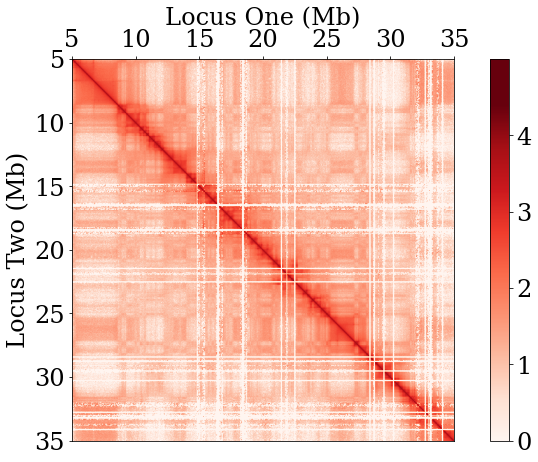

In [14]:
font = {'family' : 'serif',
        'weight':'normal',
        'size': 24}
plt.rc('font', **font)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.5)

extents = [5, 35, 35, 5]
im = ax.imshow(log_contacts, cmap="Reds", extent=extents)
ax.set_xticks([5, 10, 15, 20, 25, 30, 35])
ax.set_yticks([5, 10, 15, 20, 25, 30, 35])

# Color Bar
ticks = np.arange(np.ceil(np.max(log_contacts)))
boundaries = np.linspace(0, np.ceil(np.max(log_contacts)), 1000)

ax.set_xlabel("Locus One (Mb)")
ax.set_ylabel("Locus Two (Mb)")
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()

fig.colorbar(im, cax=cax, orientation='vertical', ticks=ticks, boundaries=boundaries)
plt.tight_layout()
plt.savefig(cmap_save_path, dpi=600)
plt.show()